# 5. Scaling, Inverse Kinematics and Inverse Dynamics


## 5.1. Objectives

**Purpose**

The purpose of this tutorial is to demonstrate how [OpenSim](https://opensim.stanford.edu/) [[1]](https://doi.org/10.1109/TBME.2007.901024) can be used to Scale a model, and then solve Inverse Kinematics (IK) and Inverse Dynamics (ID) problems using experimental data. To diagnose movement disorders and study human movement, biomechanists frequently ask human subjects to perform movements in a motion capture laboratory and use computational tools to analyze these movements. A common step in analyzing a movement is to compute the joint angles and joint moments of the subject during movement. OpenSim has tools for computing these quantities:

*   Inverse kinematics is used to compute joint angles.
*   Inverse dynamics is used to compute net joint reaction forces and net joint moments.

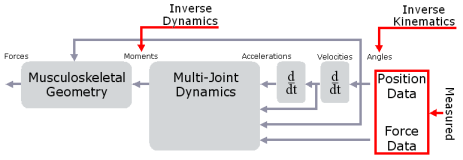

Inverse Kinematics computes the joint angles for a musculoskeletal model that best reproduce the motion of a subject. Inverse Dynamics then use joint angles, angular velocities, and angular accelerations of the model, together with the experimental ground reaction forces and moments, to solve for the net reaction forces and net moments at each of the joints. The schematic above shows an overview of the inverse kinematics and inverse dynamics problems.

In this tutorial, you will:

*   Become familiar with OpenSim's Scale, Inverse Kinematics and Inverse Dynamics tools.
*   Solve an Inverse Kinematics and an Inverse Dynamics problem using experimental data.
*   Investigate the dynamic inconsistencies that arise during Inverse Dynamics.

**Format**

Each section of the tutorial guides you through certain tools within OpenSim and asks you to answer a few questions. The questions can be answered based on information from OpenSim and basic knowledge of the human musculoskeletal system. As you complete each section of the tutorial, feel free to explore OpenSim and the lower extremity model further on your own.

## 5.2. Setup Conda and OpenSim

First, set up the environment by executing the following cell (See ***Tutorial 1: Introduction to OpenSim in Colab***).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


Now, let's install the OpenSim conda package.

In [ ]:
!conda install -c opensim-org opensim

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - opensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.24  |       ha878542_0         150 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-22.9.0               |   py37h89c1867_1         960 KB  conda-forge
    libblas-3.9.0              |16_linux64_openblas          13 KB  conda-forge
    libcblas-3.9.0             |16_linux64_openblas          13 KB  conda-forge
    libgfortran-ng-12.1.0      |      h69a702a_16          23 KB  conda-forge
    libgfortran5-12.1.0        |      hdcd56e2_16         1.8 MB  conda-forge
    liblapack-3.9.0            |16_linux64_openblas   

## 5.3. Scaling a Musculoskeletal Model

In this tutorial, you will be using a generic musculoskeletal model with 23 degrees of freedom and actuated by 54 muscles entitled 3DGaitModel2354 [[2]](https://doi.org/10.1109/10.102791) [[3]](https://doi.org/10.1080/10255849908907988).
Note: Detailed information about the model can found on the [Gait2392 and 2354 Models](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Gait+2392+and+2354+Models) page.

Subject-specific modeling involves (i) scaling a generic musculoskeletal model to modify the anthropometry, or physical dimensions, of the generic model so that it matches the anthropometry of a particular subject and (ii) registering the markers placed on the model to match the locations on the subject. Scaling and Registration are the most important steps in solving inverse kinematics and inverse dynamics problems because IK and ID solutions are sensitive to the accuracy of the scaling and registration.

A detailed explanation of the Scale Tool can be found on the [Scaling page](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Scaling) of the documentation.

**Download Files**

First, let's download the model file (gait2354_simbody.osim) from Google Drive.

In [ ]:
!gdown 1Yx2FnMYRRcass9UEuGeVu1VYtZuzzWC2

Downloading...
From: https://drive.google.com/uc?id=1Yx2FnMYRRcass9UEuGeVu1VYtZuzzWC2
To: /content/gait2354_simbody.osim
100% 333k/333k [00:00<00:00, 104MB/s]


Load the model into OpenSim. To test that the file has been downloaded correctly, let's print its name.

In [ ]:
import opensim as osim

# Load the model.
gait2354 = osim.Model('gait2354_simbody.osim')
print("Name of the model:", gait2354.getName())

Name of the model: 3DGaitModel2354


To Scale the model, we are going to use a configuration file (gait2354_Setup_Scale.xml). This Scale Setup file is an xml file that contains pre-configured settings to scale and register the generic gait2354 musculoskeletal model to the dimensions of a subject that we have experimental data for. A detailed explanation of the Scale Tool can be found on the [Scaling](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Scaling) page of the documentation. The following cell downloads the file.

In [ ]:
!gdown 1sA7Oy1IACT7AC6hugkSgLVG4qextVRXV

Downloading...
From: https://drive.google.com/uc?id=1sA7Oy1IACT7AC6hugkSgLVG4qextVRXV
To: /content/gait2354_Setup_Scale.xml
100% 31.2k/31.2k [00:00<00:00, 38.0MB/s]


We also need to download the MarketSet file (gait2354_Scale_MarkerSet.xml), which defines the position of the markers used when capturing the motion and dimensions of the subject.

In [ ]:
!gdown 1A51LoChvudI4j1Cg_6qj2Kw6e5gEmLT0

Downloading...
From: https://drive.google.com/uc?id=1A51LoChvudI4j1Cg_6qj2Kw6e5gEmLT0
To: /content/gait2354_Scale_MarkerSet.xml
100% 55.2k/55.2k [00:00<00:00, 52.8MB/s]


Finally, we need a marker file (subject01_static.trc) which provides information about the position of the markers during a motion trial. In this case, we download a file with information of the user in a static pose.

In [ ]:
!gdown 1D36gSJWCUR-XgGMN2aQngQSVg9pd5gQf

Downloading...
From: https://drive.google.com/uc?id=1D36gSJWCUR-XgGMN2aQngQSVg9pd5gQf
To: /content/subject01_static.trc
100% 496k/496k [00:00<00:00, 125MB/s]


**Create Scaler Tool**

The Scaler Tool allows to scale a model. We can pass a configuration file as a parameter, so all of the information is already available.

In [ ]:
# Create a ScaleTool object using the configuration file.
scale_tool = osim.ScaleTool('gait2354_Setup_Scale.xml')

# Print some information of the config file to test everything is correct.
print("Name:", scale_tool.getName())
print("Subject Mass:", scale_tool.getSubjectMass())
print("Subject Height:", scale_tool.getSubjectHeight())
print("Notes:", scale_tool.getPropertyByName("notes").toString())
print()

# Get model marker file name.
generic_model_marker = scale_tool.getGenericModelMaker()
print("Marker Set File Name:", generic_model_marker.getMarkerSetFileName())
print()

# Get marker file name.
marker_placer = scale_tool.getMarkerPlacer()
print("Marker Placer File Name:", marker_placer.getMarkerFileName())

Name: subject01
Subject Mass: 72.6
Subject Height: 1803.4
Notes: This is an example setup file for scale.exe.

Marker Set File Name: gait2354_Scale_MarkerSet.xml

Marker Placer File Name: subject01_static.trc


**Perform Scaling**

Finally, we can scale the model by running the scale tool. You can visualize the resulting model *subject01_simbody.osim* in [OpenSim GUI](https://simtk.org/frs/index.php?group_id=91).

In [ ]:
# Run Scale Tool.
scale_tool.run()

True

## 5.4. Inverse Kinematics

Kinematics is the study of motion without considering the forces and moments that produce that motion [4]. The purpose of inverse kinematics (IK) is to estimate the joint angles of a particular subject from experimental data. In this section, you will estimate a subject's joint angles during walking by performing an IK analysis using the subject scaled model and experimentally collected walking data. 

For each time step of recorded motion data, IK computes a set of joint angles that put the model in a configuration that "best matches" the experimental kinematics. OpenSim determines this "best match" by solving a weighted least squares optimization problem with the goal of minimizing marker error. Marker error is defined as the distance between an experimental marker and the corresponding model marker. Each marker has an associated weighting value, specifying how strongly that marker's error term should be minimized in the least squares problem. For each time step, the inverse kinematics tool solves for a vector of generalized coordinates (e.g., joint angles), $q$, that minimizes the weighted sum of marker errors, which is expressed as:

$\underset{q}{min}\Bigg[ \sum_{i \epsilon markers}{w_i || x_i^{exp} - x_i(q) ||^2}^{}\Bigg] $

where $q$ is the vector of generalized coordinates (e.g., joint angles), $x_i^{exp}$ is the position of the experimental marker $i$, $x_i(q)$ is the position of the corresponding model marker $i$ (which depends on $q$), and $w_i$ is the weight associated with marker $i$. 

A detailed explanation of the Inverse Kinematics Tool can be found on the [Inverse Kinematics page](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Inverse+Kinematics) of the documentation.

**Download the files**

First, let's download the configuration file for the Inverse Kinematics tool.

The first file to download is the xml configuration file (subject01_Setup_IK.xml) for the IK tool.

In [ ]:
!gdown 1eA10HYwolFzjHyPGzgOOmC48wK8ExSdS

Downloading...
From: https://drive.google.com/uc?id=1eA10HYwolFzjHyPGzgOOmC48wK8ExSdS
To: /content/subject01_Setup_IK.xml
100% 13.8k/13.8k [00:00<00:00, 19.4MB/s]


The second file is the marker file (dubject01_walk1.trc), which provides information about the position of the markers during a motion trial.

In [ ]:
!gdown 1QvjMuzvU1afgJ9aeCEb1Zgh9XZvo9oz7

Downloading...
From: https://drive.google.com/uc?id=1QvjMuzvU1afgJ9aeCEb1Zgh9XZvo9oz7
To: /content/subject01_walk1.trc
100% 209k/209k [00:00<00:00, 75.4MB/s]


**Create IK Tool**

The IK Tool allows to apply Inverse Kinematics to a model. We can pass a configuration file as a parameter, so all of the information is already available.

In [ ]:
# Create a ScaleTool object using the configuration file.
inverse_kinematics_tool = osim.InverseKinematicsTool('subject01_Setup_IK.xml')

# Print some information of the config file to test everything is correct.
print("Name:", inverse_kinematics_tool.getName())
print("Model File:", inverse_kinematics_tool.get_model_file())
print("Marker File:", inverse_kinematics_tool.get_marker_file())
print("Accuracy:", inverse_kinematics_tool.get_accuracy())
print("Time Range: [", inverse_kinematics_tool.get_time_range(0), ",", inverse_kinematics_tool.get_time_range(1), "]")
print("Constraint Weight:", inverse_kinematics_tool.get_constraint_weight())
print()

# Print weights information
print("Weights:")
task_set = inverse_kinematics_tool.get_IKTaskSet()
for i in range(task_set.getSize()):
  task = task_set.get(i)
  print(task.getName())
  print(task.getWeight())
  print()

Name: subject01
Model File: subject01_simbody.osim
Marker File: subject01_walk1.trc
Accuracy: 1e-05
Time Range: [ 0.4 , 1.6 ]
Constraint Weight: 20.0

Weights:
Sternum
1.0

R.Acromium
0.5

L.Acromium
0.5

Top.Head
0.1

R.ASIS
10.0

L.ASIS
10.0

V.Sacral
10.0

R.Thigh.Upper
1.0

R.Thigh.Front
1.0

R.Thigh.Rear
1.0

R.Shank.Upper
1.0

R.Shank.Front
1.0

R.Shank.Rear
1.0

R.Heel
10.0

R.Midfoot.Sup
1.0

R.Midfoot.Lat
1.0

R.Toe.Lat
1.0

R.Toe.Med
1.0

R.Toe.Tip
10.0

L.Thigh.Upper
1.0

L.Thigh.Front
1.0

L.Thigh.Rear
1.0

L.Shank.Upper
1.0

L.Shank.Front
1.0

L.Shank.Rear
1.0

L.Heel
10.0

L.Midfoot.Sup
1.0

L.Midfoot.Lat
1.0

L.Toe.Lat
1.0

L.Toe.Med
1.0

L.Toe.Tip
10.0

subtalar_angle_r
1000.0

mtp_angle_r
1000.0

subtalar_angle_l
1000.0

mtp_angle_l
1000.0



4. Which markers have weighting values less than one? Why?
Hint: Think about joints that have not been modeled.

**Perform Inverse Kinematics**

Finally, we can scale the model by running the IK tool. You can visualize the resulting motion file (subject01_simbody.osim) by associating it to the scaled model (subject01_walk1_ik.mot) in [OpenSim GUI](https://simtk.org/frs/index.php?group_id=91).

In [ ]:
inverse_kinematics_tool.run()

True

**Visualize IK marker errors**

The file subject01_ik_marker_errors.sto provides the markers errors associated with each frame of the generated motion. You can parse this file using a Table Processor and visualize the error obtained per frame.

In [ ]:
# Use the TableProcessor to read the motion file.
table = osim.TableProcessor("subject01_ik_marker_errors.sto")
# Process the file.
tableTime = table.process()
# Print labels for each column.
print(tableTime.getColumnLabels())

('total_squared_error', 'marker_error_RMS', 'marker_error_max')


We will plot te total squared error, the RMS error for the markers, and the maximum error for the markers. In the next cell you will extract this information from the motion file.


In [ ]:
# Get columns we want to represent, and the independent column (Time).
total_squared_error = tableTime.getDependentColumn('total_squared_error')
marker_error_RMS = tableTime.getDependentColumn('marker_error_RMS')
marker_error_max = tableTime.getDependentColumn('marker_error_max')
x_time = tableTime.getIndependentColumn()

Now, we can use this information to visually observe the error.

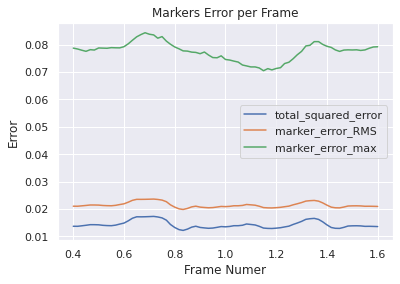

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()
sns.lineplot(x=x_time, y=total_squared_error.to_numpy(), label='total_squared_error')
sns.lineplot(x=x_time, y=marker_error_RMS.to_numpy(), label='marker_error_RMS')
sns.lineplot(x=x_time, y=marker_error_max.to_numpy(), label='marker_error_max').set(title='Markers Error per Frame', xlabel='Frame Numer', ylabel='Error');

5. What is the root-mean-squared (RMS) error of all the markers in the last frame of the motion? Include units. Does this seem reasonable? Explain.

6. What was the value of the maximum marker error in the last frame? Include units. Which marker had this maximum error, and why?
Hint: Think about the weighted least squares problem.

## 5.5. Inverse Dynamics

Dynamics is the study of motion and the forces and moments that produce that motion [4]. To perform inverse dynamics, estimation of mass and inertia is required. The purpose of inverse dynamics is to estimate the forces and moments that cause a particular motion, and its results can be used to infer how muscles are utilized in that motion. To determine these forces and moments, equations of motion for the system are solved iteratively [[5]](https://doi.org/10.1115/1.2834295). The equations of motion are derived using the kinematic description and mass properties of a musculoskeletal model. Then, using the joint angles from inverse kinematics and experimental ground reaction force data, the net reaction forces and net moments at each of the joints are calculated such that the dynamic equilibrium conditions and boundary conditions are satisfied [[5]](https://doi.org/10.1115/1.2834295).  

A detailed explanation of the Inverse Dynamics Tool can be found on the [Inverse Dynamics page](https://simtk-confluence.stanford.edu:8443/display/OpenSim/Inverse+Dynamics) of the documentation.

**Download the files**

First, let's download the configuration file (subject01_Setup_InverseDynamics.xml) for the Inverse Dynamics tool.

In [ ]:
!gdown 1aZJmbykxdTrC_Uo9oDO_9xgfTUmLzjpI

Downloading...
From: https://drive.google.com/uc?id=1aZJmbykxdTrC_Uo9oDO_9xgfTUmLzjpI
To: /content/subject01_Setup_InverseDynamics.xml
100% 1.65k/1.65k [00:00<00:00, 2.62MB/s]


The second file is a external loads file (subject01_walk1_grf.xml), that contains the external loads applied to the model.

In [ ]:
!gdown 14aOk5udB8pgafettraCZgv3ULnAWzvyI

Downloading...
From: https://drive.google.com/uc?id=14aOk5udB8pgafettraCZgv3ULnAWzvyI
To: /content/subject01_walk1_grf.xml
100% 2.56k/2.56k [00:00<00:00, 4.44MB/s]


The third file is a coordinates file (subject01_walk1_grf.mot), containing coordinate data.

In [ ]:
!gdown 1m0PTgw8K1dW0koHhgn6Wfci0498JsGF-

Downloading...
From: https://drive.google.com/uc?id=1m0PTgw8K1dW0koHhgn6Wfci0498JsGF-
To: /content/subject01_walk1_grf.mot
100% 224k/224k [00:00<00:00, 104MB/s]


**Create ID Tool**

The IK Tool allows to apply Inverse Dynamics to a model. We can pass a configuration file as a parameter, so all of the information is already available.

In [ ]:
# Create a ScaleTool object using the configuration file.
inverse_dynamics_tool = osim.InverseDynamicsTool('subject01_Setup_InverseDynamics.xml')

# Print some information of the config file to test everything is correct.
print("Name:", inverse_dynamics_tool.getName())
print("Model File:", inverse_dynamics_tool.getModelFileName())
print("External Loads File:", inverse_dynamics_tool.getExternalLoadsFileName())
print("Coordinates File:", inverse_dynamics_tool.getCoordinatesFileName())
print("Time Range: [", inverse_dynamics_tool.getStartTime(), ",", inverse_dynamics_tool.getEndTime(), "]")
print("Lowpass Cutoff Frecuency:", inverse_dynamics_tool.getLowpassCutoffFrequency())
print()

Name: subject01_walk1
Model File: subject01_simbody.osim
External Loads File: subject01_walk1_grf.xml
Coordinates File: subject01_walk1_ik.mot
Time Range: [ 0.4 , 1.6 ]
Lowpass Cutoff Frecuency: 6.0



**Run Inverse Dynamics**

Finally, we can run Inverse Dynamics by running the Inverse Dynamics tool. You can visualize the resulting motion file (subject01_simbody.osim) by associating it to the scaled model (subject01_walk1_ik.mot) in [OpenSim GUI](https://simtk.org/frs/index.php?group_id=91).

In [ ]:
inverse_dynamics_tool.run()

True

**Visualize ID results**

After running the Inverse Dynamics Tool, a file named inverse_dynamics.sto is generated. This file contains the results of the Inverse Dynamics execution, and you can parse it using a Table Processor to visualize the results.

In [ ]:
# Use the TableProcessor to read the motion file.
table = osim.TableProcessor("ResultsInverseDynamics/inverse_dynamics.sto")
# Process the file.
tableTime = table.process()
# Print labels for each column.
print(tableTime.getColumnLabels())

('pelvis_tilt_moment', 'pelvis_list_moment', 'pelvis_rotation_moment', 'pelvis_tx_force', 'pelvis_ty_force', 'pelvis_tz_force', 'hip_flexion_r_moment', 'hip_adduction_r_moment', 'hip_rotation_r_moment', 'hip_flexion_l_moment', 'hip_adduction_l_moment', 'hip_rotation_l_moment', 'lumbar_extension_moment', 'lumbar_bending_moment', 'lumbar_rotation_moment', 'knee_angle_r_moment', 'knee_angle_l_moment', 'ankle_angle_r_moment', 'ankle_angle_l_moment', 'subtalar_angle_r_moment', 'subtalar_angle_l_moment', 'mtp_angle_r_moment', 'mtp_angle_l_moment')


We are going to compare the moments of the knee angle of both legs, so let's extract them from the motion file.

In [ ]:
# Get columns we want to represent, and the independent column (Time).
ankle_angle_r_moment = tableTime.getDependentColumn('ankle_angle_r_moment')
ankle_angle_l_moment = tableTime.getDependentColumn('ankle_angle_l_moment')
x_time = tableTime.getIndependentColumn()

Now, we can use this information to visually observe the error.

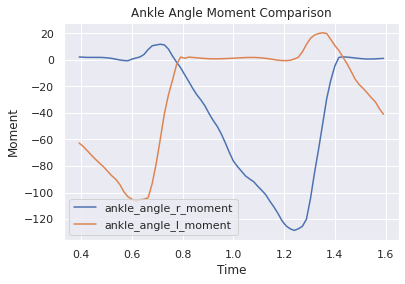

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()
sns.lineplot(x=x_time, y=ankle_angle_r_moment.to_numpy(), label='ankle_angle_r_moment')
sns.lineplot(x=x_time, y=ankle_angle_l_moment.to_numpy(), label='ankle_angle_l_moment').set(title='Ankle Angle Moment Comparison', xlabel='Time', ylabel='Moment');

7. On your plot of the ankle moments, identify when heel strike, stance phase, toe off, and swing phase occur for each curve (i.e., left leg and right leg).

8. Based on your plot and the angle convention for the ankle, give an explanation of what is happening at the ankle just before toe-off.
Hint: It may be useful to use the Coordinate sliders to understand the angle convention for the ankle.

In solving the inverse dynamics problem, both kinematic data and force plate data were used, making this an over-determined problem. In other words, the problem has more equations than unknowns (i.e., degrees of freedom). Due to errors in the experimental motion data and inaccuracies in the musculoskeletal model, it turns out that Newton's second law is violated, or $\overrightarrow{F}_{exp} \neq m * \overrightarrow{a}$ [[5]](https://doi.org/10.1115/1.2834295). One method to handle this inconsistency is to compute and apply residual forces and moments to a particular body segment in the model, such that Newton's second law becomes:

$\overrightarrow{F}_{exp} + \overrightarrow{F}_{residual} = m * \overrightarrow{a} ^†$

$†$ An analogous equation relates the ground reaction moment, $\overrightarrow{M}_{exp}$ to the residual moment, $\overrightarrow{M}_{residual}$.

In this musculoskeletal model, the residuals are applied to the pelvis segment. To see the residuals from the inverse dynamics solution, plot `pelvis_tx_force`, `pelvis_ty_force`, and `pelvis_tz_force` versus `time`. Using this plot, answer question 9.

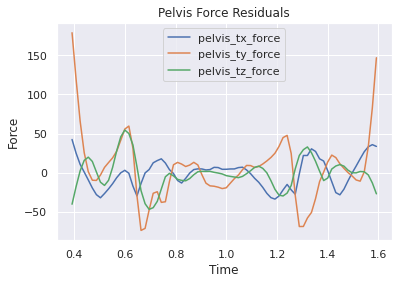

In [ ]:
# Get columns we want to represent, and the independent column (Time).
pelvis_tx_force = tableTime.getDependentColumn('pelvis_tx_force')
pelvis_ty_force = tableTime.getDependentColumn('pelvis_ty_force')
pelvis_tz_force = tableTime.getDependentColumn('pelvis_tz_force')
x_time = tableTime.getIndependentColumn()

# Plot extracted values.
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set()
sns.lineplot(x=x_time, y=pelvis_tx_force.to_numpy(), label='pelvis_tx_force')
sns.lineplot(x=x_time, y=pelvis_ty_force.to_numpy(), label='pelvis_ty_force')
sns.lineplot(x=x_time, y=pelvis_tz_force.to_numpy(), label='pelvis_tz_force').set(title='Pelvis Force Residuals', xlabel='Time', ylabel='Force');

9. What are the maximum magnitudes of the residual forces? Using the mass of the subject from Question 1, what fraction of body weight are the maximum residual forces?

While applying residual forces and moments makes the model's motion dynamically consistent with the external forces, this strategy is undesirable because the residuals can be large. More advanced strategies have been developed to deal with the problem of residuals and dynamic inconsistencies, such as least-squares optimization [[5]](https://doi.org/10.1115/1.2834295), the Residual Elimination Algorithm (REA) [[6]](https://doi.org/10.1016/j.jbiomech.2005.02.010), and the Residual Reduction Algorithm (RRA) [[7]](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.91.818&rep=rep1&type=pdf#page=31). OpenSim implements a Residual Reduction Algorithm as part of its workflow for generating muscle-actuated simulations [[7]](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.91.818&rep=rep1&type=pdf#page=31). A detailed explanation of the Residual Reduction Algorithm (RRA) can be found on the Residual Reduction Algorithm page of the documentation. For additional information on these strategies, please also see [[1]](https://doi.org/10.1080/10255842.2011.627560), [[5]](https://doi.org/10.1115/1.2834295), [[6]](https://doi.org/10.1016/j.jbiomech.2005.02.010) and [[7]](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.91.818&rep=rep1&type=pdf#page=31).

## 5.6. Conclusion

In this tutorial you have Scaled a musculoskeletal model, and then performed an Inverse Kinematics analysis and an Inverse Dynamics analysis to it. Then you have explored the results of the two analyses.

## 5.7. Acknowledgements

The experimental gait data were collected by Jill Higginson and Chand John in the Neuromuscular Biomechanics Lab at the University of Delaware [[8]](https://doi.org/10.1080/10255842.2011.627560). The data include marker trajectories and ground reaction forces for an adult male walking at a self-selected speed on an instrumented split-belt treadmill. Please note that the data distributed with OpenSim is from a different subject than the one described in the paper. Data collection protocols were the same for both subjects.

## 5.8. Useful Links





> **OpenSim Website:** https://opensim.stanford.edu/
>
> **OpenSim API Documentation:** https://simtk.org/api_docs/opensim/api_docs/
> 
> **OpenSim Creator Website:** https://opensimcreator.com/
> 
> **SimTK Website:** https://simtk.org/projects/opensim
> 
> **Biomecanics of Movement's Course:** https://www.youtube.com/channel/UCDNGy0KKNLQ-ztcL5h2Z6zA

## 5.9. References


> [1].   Delp, S. L., Anderson, F. C., Arnold, A. S., Loan, P., Habib, A., John, C. T., Guendelman, E., & Thelen, D. G. (2007). **OpenSim: open-source software to create and analyze dynamic simulations of movement.** *IEEE Transactions on Bio-Medical Engineering*, 54(11), 1940–1950. https://doi.org/10.1109/TBME.2007.901024
> 
> [2].   Delp, S. L., Loan, J. P., Hoy, M. G., Zajac, F. E., Topp, E. L., & Rosen, J. M. (1990). **An interactive graphics-based model of the lower extremity to study orthopaedic surgical procedures.** *IEEE Transactions on Bio-Medical Engineering*, 37(8), 757–767. https://doi.org/10.1109/10.102791
>
> [3]. Anderson, F. C., & Pandy, M. G. (1999). **A dynamic optimization solution for vertical jumping in three dimensions.** *Computer Methods in Biomechanics and Biomedical Engineering*, 2(3), 201–231. https://doi.org/10.1080/10255849908907988
>
> [4]. Winter, D. A. (1990). **The biomechanics and motor control of human movement** (2a ed.). *John Wiley & Sons*.
>
> [5]. Kuo, A. D. (1998). **A least-squares estimation approach to improving the precision of inverse dynamics computations.** *Journal of Biomechanical Engineering*, 120(1), 148–159. https://doi.org/10.1115/1.2834295
>
> [6]. Thelen, D. G., & Anderson, F. C. (2006). **Using computed muscle control to generate forward dynamic simulations of human walking from experimental data.** *Journal of Biomechanics*, 39(6), 1107–1115. https://doi.org/10.1016/j.jbiomech.2005.02.010
>
> [7]. John, C.T., Anderson, F.C., Guendelman, E., Arnold, A.S., Delp, S.L. (21st October 2006). **An algorithm for generating muscle-actuated simulations of long-duration movements.** *Biomedical Computation at Stanford (BCATS) Symposium*, Stanford University, Poster Presentation. https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.91.818&rep=rep1&type=pdf#page=31
>
> [8]. John, C. T., Anderson, F. C., Higginson, J. S., & Delp, S. L. (2013). **Stabilisation of walking by intrinsic muscle properties revealed in a three-dimensional muscle-driven simulation.** *Computer Methods in Biomechanics and Biomedical Engineering*, 16(4), 451–462. https://doi.org/10.1080/10255842.2011.627560